In [349]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import xmltodict as xd
import datetime as dt

from matplotlib import rc
from matplotlib import cm

rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

%matplotlib inline

# This enables SVG graphics inline.
%config InlineBackend.figure_formats = {'png', 'retina'}

rc = {'lines.linewidth': 2,
      'axes.labelsize': 18,
      'axes.titlesize': 18,
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 14

In [368]:
# fetch NYT data:
# url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv'
# nyt = pd.read_csv(url, usecols=[0, 1, 3, 4], parse_dates=['date'], squeeze=True)

# # fetch census data:
# pop = pd.read_excel('../data/nst-est2019-01.xlsx', comment='#', header=1)
# pop.columns = np.append(np.array(['state']), pop.columns[1:].values)
# pop.state = pop.state.str.strip('.')

# # merge dfs:
# nyt = nyt.merge(pop, left_on='state', right_on='state')

# calculate per population numbers:
nyt['normedPopCases'] = nyt.cases/ nyt[2019]
nyt['normedPopDeaths'] = nyt.deaths / nyt[2019]

ma = nyt[nyt.state == "Massachusetts"].copy()
ma.sort_values('date', inplace=True)
diffsum = lambda x: np.sum(x.diff())
ma['WeeklyCases'] = ma.groupby(pd.Grouper(key='date', freq='W')).normedPopCases.transform(diffsum)

input_path = '../data/export.xml'
with open(input_path, 'r') as xml_file:
    input_data = xd.parse(xml_file.read())
    
df = pd.DataFrame(input_data['HealthData']['Record'])

# cleanup:
df.columns = [c[1:] if '@' in c else c for c in df.columns]
df.columns = [c[0].upper() + c[1:] for c in df.columns]
df.StartDate = pd.to_datetime(df.StartDate)
df.CreationDate = pd.to_datetime(df.CreationDate)
df.EndDate = pd.to_datetime(df.EndDate)
df['Date'] = pd.to_datetime(df.StartDate.dt.date)

print(df.Date.min())
df = df.merge(ma[['date', 'normedPopCases', 'WeeklyCases']],
              left_on='Date', right_on='date', how='outer')
print(df.Date.min())
def trim(x):
    """Remove some useless substring"""
    if 'HKQuantityTypeIdentifier' in x:
        return x[len('HKQuantityTypeIdentifier'):]
    elif 'HKCategoryTypeIdentifier' in x:
        return x[len('HKCategoryTypeIdentifier'):]
    else:
        return x
    
df.Type = df.Type.apply(trim)

drop = ['Height']
for n, g in df.groupby(['Type']):
    try:
        g.Value.astype(np.float)
        if g.Value.astype(np.float).std() == 0:
            drop += [n]
        elif len(g) < 50:
            drop += [n]
    except:
        drop += [n]

# drop useless types:
df = df[~df.Type.isin(drop)].copy()
# to float:
df.Value = df.Value.astype(np.float)

# normalize:
df['NormedValue'] = (df.Value - df.groupby('Type').Value.transform(np.mean)) / df.groupby('Type').Value.transform(np.std)

print('Measurement types:')
print(df.Type.unique())

2019-08-01 00:00:00
2019-08-01 00:00:00
Measurement types:
['StepCount' 'DistanceWalkingRunning' 'BodyMassIndex' 'Height' 'BodyMass'
 'HeartRate' 'BodyFatPercentage' 'LeanBodyMass' 'BasalEnergyBurned'
 'ActiveEnergyBurned' 'FlightsClimbed' 'RestingHeartRate' 'VO2Max'
 'WalkingHeartRateAverage' 'EnvironmentalAudioExposure' 'AppleStandTime'
 'HeartRateVariabilitySDNN' 'WalkingDoubleSupportPercentage'
 'WalkingSpeed' 'WalkingStepLength' 'WalkingAsymmetryPercentage'
 'StairAscentSpeed' 'StairDescentSpeed' 'SwimmingStrokeCount']


In [246]:
df.head()

,Type,SourceName,SourceVersion,Unit,CreationDate,StartDate,EndDate,Value,MetadataEntry,Device,HeartRateVariabilityMetadataList,Date,date,normedPopCases,NormedValue
0,BodyMassIndex,EufyLife,7,count,2020-07-13 14:24:08-05:00,2020-07-13 14:22:30-05:00,2020-07-13 14:22:30-05:00,28.58130,NaN,NaN,NaN,2020-07-13,2020-07-13,0.016224,2.434774
1,BodyMassIndex,EufyLife,7,count,2020-07-13 14:24:08-05:00,2020-07-13 14:22:56-05:00,2020-07-13 14:22:56-05:00,28.58130,NaN,NaN,NaN,2020-07-13,2020-07-13,0.016224,2.434774
2,BodyMassIndex,EufyLife,7,count,2020-07-13 14:24:29-05:00,2020-07-13 14:24:28-05:00,2020-07-13 14:24:28-05:00,27.59860,NaN,NaN,NaN,2020-07-13,2020-07-13,0.016224,0.576156
3,BodyMassIndex,EufyLife,7,count,2020-07-14 07:15:07-05:00,2020-07-13 20:59:59-05:00,2020-07-13 20:59:59-05:00,27.73230,NaN,NaN,NaN,2020-07-13,2020-07-13,0.016224,0.829028
4,Height,EufyLife,7,ft,2020-07-13 14:24:08-05:00,2020-07-13 14:24:08-05:00,2020-07-13 14:24:08-05:00,5.67585,NaN,NaN,NaN,2020-07-13,2020-07-13,0.016224,-inf


(-5, 5)

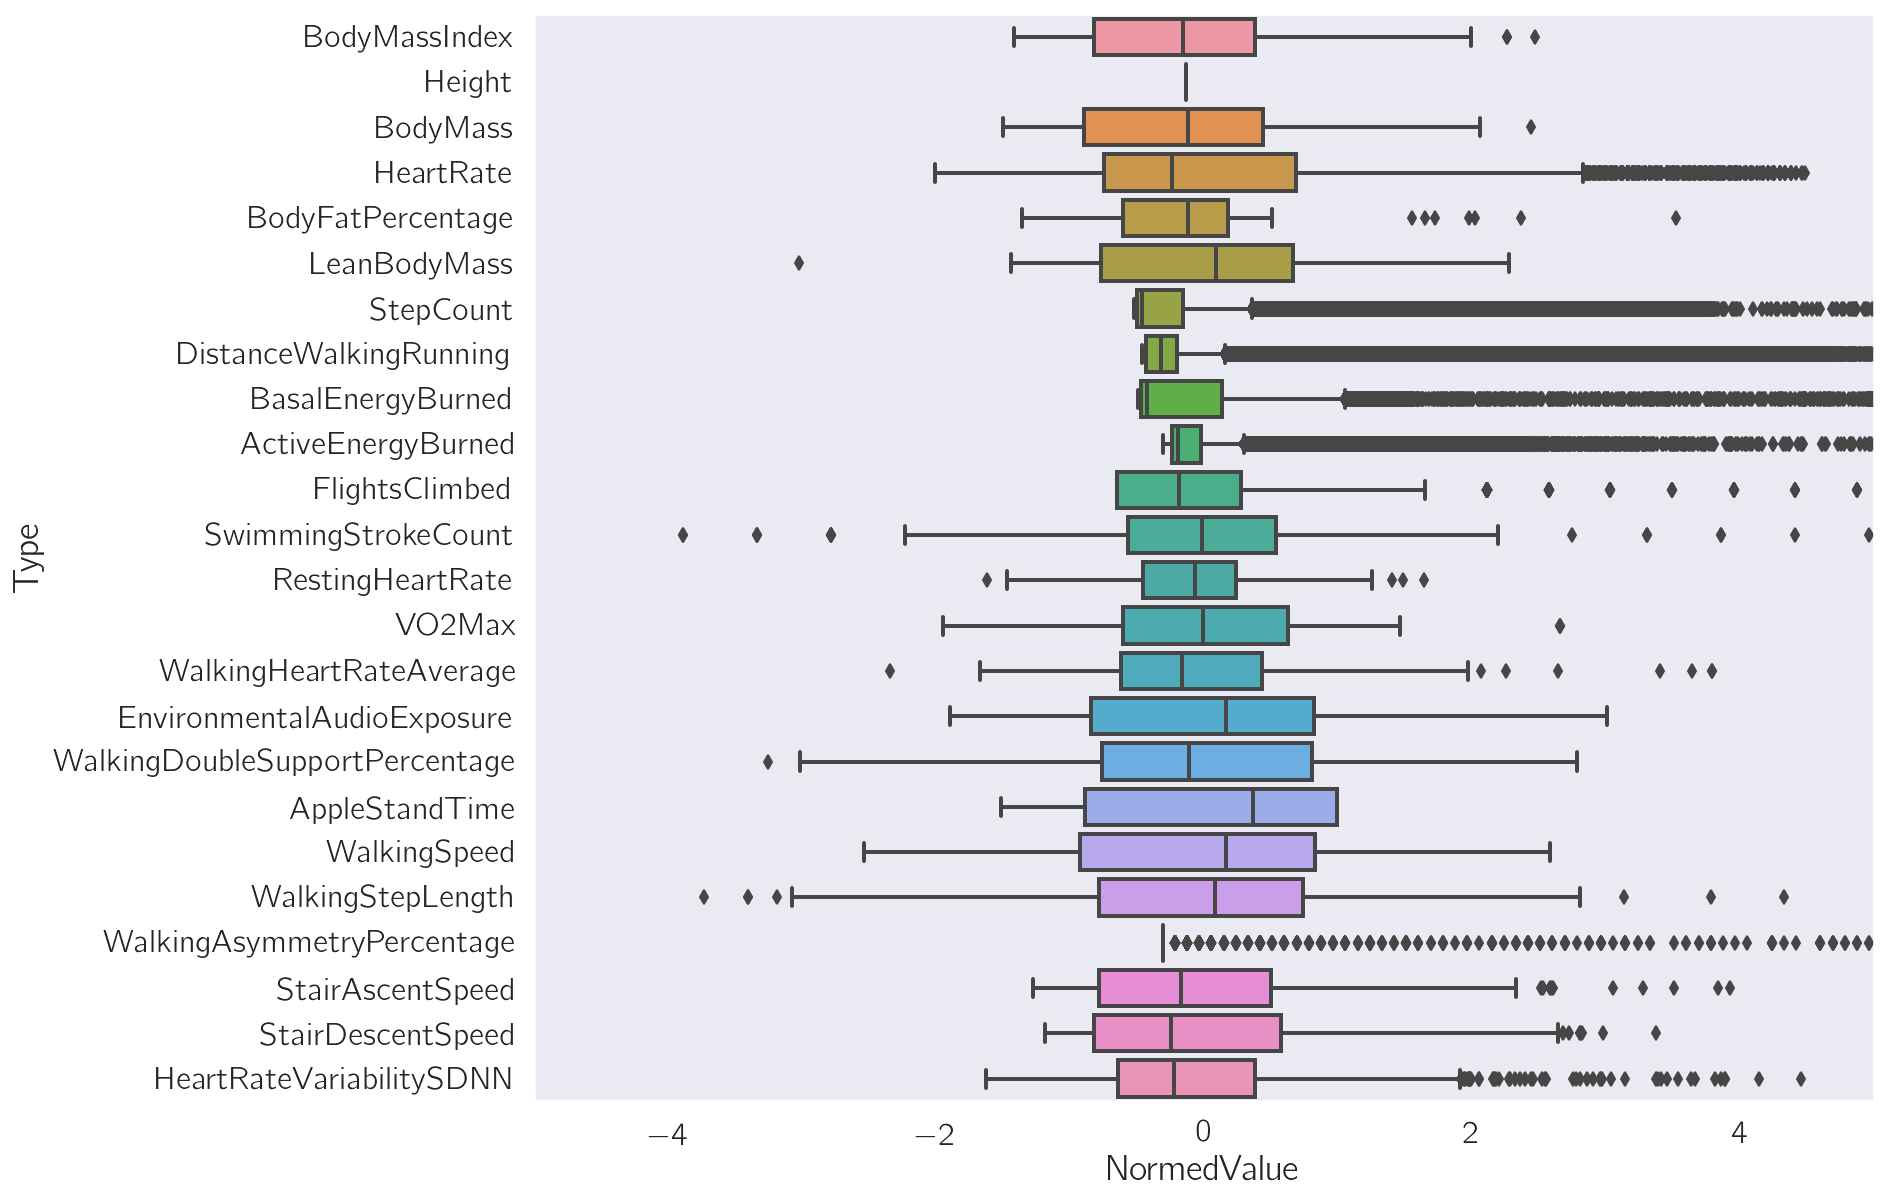

In [209]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.boxplot('NormedValue', 'Type', data=df)
plt.xlim(-5, 5)

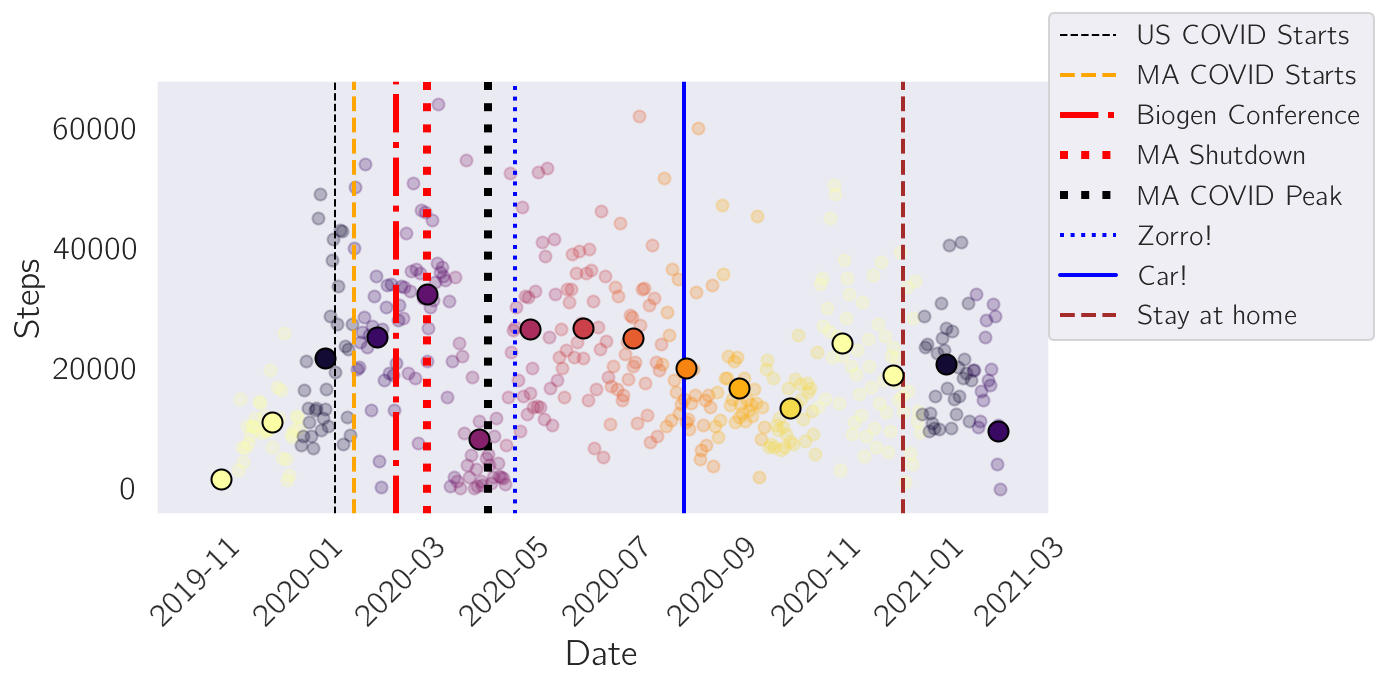

In [393]:
fig, ax = plt.subplots(figsize=(8, 4))
cmap = cm.get_cmap('inferno', 12)

i = 0
for n, g in df.groupby(['Type', pd.Grouper(key='StartDate', freq='D')]):
    if n[0] == 'StepCount':
        color = g.StartDate.dt.month.unique()[0] / 12.
        x = g.StartDate.dt.date.unique()
        y = g.Value.sum()
        plt.scatter(x=x, y=y, c=[cmap(color)], alpha=0.25)
        i += 1

for n, g in df.groupby(['Type', pd.Grouper(key='StartDate', freq='M')]):
    if n[0] == 'StepCount':
        color = g.StartDate.dt.month.unique()[0] / 12.
        x = g.StartDate.dt.date.unique()[0]
        y = g.Value.sum() / 30
        plt.scatter(dt.datetime(int(x.year), int(x.month), 15), y, c=[cmap(color)],
                 edgecolor='black', s=100, zorder=np.inf)
        i += 1

plt.axvline(nyt[nyt.cases == 1].date.min(), ls='--', color='black', label='US COVID Starts', lw=1)
plt.axvline(ma[ma.cases == 1].date.min(), ls='--', color='orange', label='MA COVID Starts', lw=2)
plt.axvline(dt.datetime(2020, 2, 26), ls='-.', color='red', label='Biogen Conference', lw=3)
plt.axvline(dt.datetime(2020, 3, 15), ls=':', color='red', label='MA Shutdown', lw=4)
plt.axvline(dt.datetime(2020, 4, 20), ls=':', color='black', label='MA COVID Peak', lw=4)
plt.axvline(dt.datetime(2020, 5, 6), ls=':', color='blue', label='Zorro!', lw=2)
plt.axvline(dt.datetime(2020, 8, 14), ls='-', color='blue', label='Car!', lw=2)
plt.axvline(dt.datetime(2020, 12, 21), ls='--', color='brown', label='Stay at home', lw=2)
ax.format_xdata = mdates.DateFormatter('%Y-%m')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Steps')
_ = plt.legend(loc=(1, .4))

No handles with labels found to put in legend.


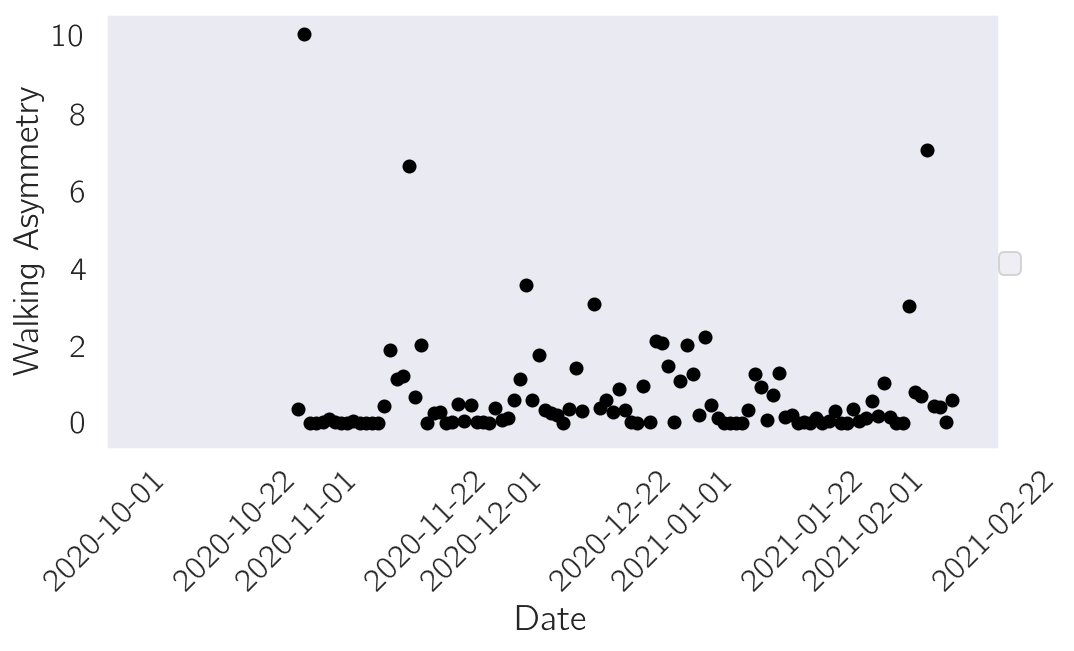

In [400]:
fig, ax = plt.subplots(figsize=(8, 4))
cmap = cm.get_cmap('cividis', 12)

i = 0
for n, g in df.groupby(['Type', pd.Grouper(key='StartDate', freq='D')]):
    if n[0] == 'WalkingAsymmetryPercentage':
        color = g.StartDate.dt.month.unique()[0] / 12.
        x = g.StartDate.dt.date.unique()
        y = g.Value.sum()
        plt.scatter(x, y, c='black')
        i += 1

plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Walking Asymmetry')
_ = plt.legend(loc=(1, .4))